# Learning and Decision Making

## Laboratory 4: Partially observable Markov decision problems

In the end of the lab, you should submit all code/answers written in the tasks marked as "Activity n. XXX", together with the corresponding outputs and any replies to specific questions posed to the e-mail <adi.tecnico@gmail.com>. Make sure that the subject is of the form [&lt;group n.&gt;] LAB &lt;lab n.&gt;.

### 1. Modeling

Consider once again the guessing game domain described in the Homework and which you described as a POMDP.

Recall that:

* The opponent can hold one of two cards in hand: an Ace of Clubs (A&clubs;) and an Ace of Diamonds (A&diams;). The agent must guess which card the opponent is holding. 

* For every right answer, the agent wins 1EUR, and every wrong answer costs the agent 1EUR. 

* The agent can also try to _peek_. 

* When the agent peeks, it sees the right card with a probability of 0.9 and the wrong card with probability 0.1.

* The game restarts whenever the agent makes a guess.

Consider throughout that $\gamma=0.9$.

---

#### Activity 1.        

Implement your POMDP in Python. In particular,

* Create a list with all the states;
* Create a list with all the actions;
* Create a list with all the observations
* For each action, define a `numpy` array with the corresponding transition probabilities;
* For each action, define a `numpy` array with the corresponding observation probabilities;
* Define a `numpy`array with the cost that you defined in your homework.

The order for the states and actions used in the transition probability and cost matrices should match that in the lists of states and actions. 

**Note**: Don't forget to import `numpy`.

---

In [2]:
import numpy as np

#states
X = ['C', 'D']
#actions
A = ['choose C', 'choose D', 'peek']
#observations
Z = ['sees C', 'sees D', 'sees none']
#discounted cost
gamma = 0.9

#transition probabilities
Pclubs = Pdiamonds = np.array([[0.5, 0.5],\
                               [0.5, 0.5]])
Ppeek = np.array([[1, 0],\
                  [0, 1]])

#observation probabilities
Oclubs = Odiamonds = np.array([[0, 0, 1],\
                               [0, 0, 1]])
Opeek = np.array([[0.9, 0.1, 0],\
                  [0.1, 0.9, 0]])

#cost function
C = np.array([[0, 1, 0.5],\
              [1, 0, 0.5]])

### 2. Sampling

You are now going to sample random trajectories of your POMDP and observe the impact it has on the corresponding belief.

---

#### Activity 2.

Generate a random POMDP trajectory using a uniformly random policy. In particular, from a random initial state $x_0$ generate:

1. A sequence of 10,000 states by selecting the actions uniformly at random;
2. The corresponding sequence of 10,000 actions;
3. The corresponding sequence of 10,000 observations.

---

In [3]:
from numpy import random as rand

#mapping strings to matrixes
prob_action = {'choose C': Pclubs, 'choose D': Pdiamonds, 'peek': Ppeek}
prob_obs = {'choose C': Oclubs, 'choose D': Odiamonds, 'peek': Opeek}
#mapping string to matrixes rows
obs_line = {'sees C': 0, 'sees D': 1, 'sees none': 2}
state_line = {'C': 0, 'D': 1}

step = 0
states = []
actions = []
obs = []

#first state random
state = rand.choice(X)
states.append(state)

while step < 10000:
    #policy of choosing a random action
    action = rand.choice(A)
    actions.append(action)
    
    #calculate the correspondent observation
    observation = rand.choice(Z, 1, p = prob_obs[action][state_line[state]])[0]
    obs.append(observation)
    
    #calculate the next state
    state = rand.choice(X, 1, p = prob_action[action][state_line[state]])[0]
    states.append(state)
    
    step += 1

#delete the last state (not necessary)
del states[-1]

#print(states)
#print(actions)
#print(obs)

---

#### Activity 3.

For the POMDP trajectory generated in Activity 2, compute the corresponding sequence of beliefs, assuming that the initial belief is $\mathbf{b}_0=[0.5, 0.5]$. Report the resulting beliefs, ignoring duplicate beliefs or beliefs whose distance is smaller than $10^{-4}$.

**Note 1:** You may want to define a function `belief_update` that receives a belief, an action and an observation and returns the updated belief.

**Note 2:** To compute the distance between vectors, you may find useful `numpy`'s function `linalg.norm`.


---

In [4]:
from numpy import linalg as l

belief = np.array([0.5, 0.5])
belief_list = []
belief_list.append(belief)
norms = []
norms.append(l.norm(belief))
step = 0

def belief_update(belief, action, observation):
    #get the transition probability
    A = prob_action[action]
    #get the diagonal of the observation probability
    O = np.diag(prob_obs[action][:, obs_line[observation]])
    #apply the formula to calculate the updated belief
    alpha0 = belief
    alpha1 = np.dot(alpha0, A)
    new_belief = np.dot(alpha1, O)
    
    return new_belief/np.sum(new_belief)

while step < 10000:
    #calculate the next belief
    new_belief = belief_update(belief, actions[step], obs[step])
    #verify if it's a different belief
    if all(abs(l.norm(new_belief - b)) > 1e-4 for b in belief_list):
        belief_list.append(new_belief)
    belief = new_belief
    step += 1
    
print(belief_list)

[array([ 0.5,  0.5]), array([ 0.9,  0.1]), array([ 0.98780488,  0.01219512]), array([ 0.1,  0.9]), array([ 0.01219512,  0.98780488]), array([ 0.00136986,  0.99863014]), array([  1.52392563e-04,   9.99847607e-01]), array([ 0.99863014,  0.00136986]), array([  9.99847607e-01,   1.52392563e-04]), array([  1.69348010e-05,   9.99983065e-01]), array([  9.99983065e-01,   1.69348010e-05])]


### 3. Solution methods

In this section you are going to compare different non-exact solution methods.

---

#### Activity 4

Compute the solution for the underlying MDP and report the corresponding optimal policy and optimal cost-to-go. 

** Note:** You may reuse code from previous labs.

---

In [5]:
#Value Iteration to calculate the optimal cost-to-go
J = np.zeros((2,1))
err = 1
i = 0

chooseC = np.reshape(C[:, 0], (2, 1))
chooseD = np.reshape(C[:, 1], (2, 1))
peek = np.reshape(C[:, 2], (2, 1))

while err > 1e-8:
    Qc = chooseC + gamma * Pclubs.dot(J)
    Qd = chooseD + gamma * Pdiamonds.dot(J)
    Qp = peek + gamma * Ppeek.dot(J)
    
    Jnew = np.min((Qc, Qd, Qp), axis = 0)
    err = np.linalg.norm(Jnew - J)
    i += 1
    J = Jnew
    
print("optimal cost-to-go:")
print(J)

#Policy Iteration to calculate the optimal policy
pi = np.ones((2,1)) / 2
quit = False
i = 0

while not quit:
    pinew = np.zeros((2,3))
    pinew[:, 0, None] = np.isclose(Qc, np.min((Qc, Qd, Qp), axis=0), atol=1e-8, rtol = 1e-8).astype(int)
    pinew[:, 1, None] = np.isclose(Qd, np.min((Qc, Qd, Qp), axis=0), atol=1e-8, rtol = 1e-8).astype(int)
        
    pinew = pinew / np.sum(pinew, axis = 1, keepdims = True)
    
    quit = (pi == pinew).all()
    pi = pinew
    i += 1

print("optimal policy:")
print(pi)

optimal cost-to-go:
[[ 0.]
 [ 0.]]
optimal policy:
[[ 1.  0.  0.]
 [ 0.  1.  0.]]


---

#### Activity 5

For each of the beliefs computed in Activity 3, compute the action prescribed by:

* The MLS heuristic;
* The AV heuristic;
* The Q-MDP heuristic.

---

In [6]:
#MLS heuristic
MLS_actions = []
#calculate the max probability for each belief
for b in belief_list:
    M = np.max(b)
    if M == b[0]:
        MLS_actions.append(A[0])
    elif M == b[1]:
        MLS_actions.append(A[1])

#AV heuristic is a vote between all states and the most voted action is executed.
#Since we have 2 states it will be the same as MLS heuristic
AV_actions = MLS_actions

#Q-MDP heuristic
QMDP_actions = []
Qactions = [Qc, Qd, Qp]
Pvector = []

for b in belief_list:
    #calculate the cost-to-go for each action
    for Q in Qactions:
        Pvector.append(np.dot(b, Q))
    #chooce the action that minimizes the cost
    m = np.min(Pvector)
    if m == Pvector[0]:
        QMDP_actions.append(A[0])
    elif m == Pvector[1]:
        QMDP_actions.append(A[1])
    elif m == Pvector[2]:
        QMDP_actions.append(A[2])
    Pvector = []

print("MLS heuristic:", MLS_actions)
print("AV heuristic:", MLS_actions)
print("Q-MDP heuristic:", QMDP_actions)

MLS heuristic: ['choose C', 'choose C', 'choose C', 'choose D', 'choose D', 'choose D', 'choose D', 'choose C', 'choose C', 'choose D', 'choose C']
AV heuristic: ['choose C', 'choose C', 'choose C', 'choose D', 'choose D', 'choose D', 'choose D', 'choose C', 'choose C', 'choose D', 'choose C']
Q-MDP heuristic: ['choose C', 'choose C', 'choose C', 'choose D', 'choose D', 'choose D', 'choose D', 'choose C', 'choose C', 'choose D', 'choose C']


---

#### Activity 6

Suppose that the optimal cost-to-go function for the POMDP can be represented using the $\alpha$-vectors

$$
\left\{
\begin{bmatrix}
2.795\\
3.795
\end{bmatrix},
\begin{bmatrix}
3.795\\
2.795
\end{bmatrix},
\begin{bmatrix}
3.105\\
3.105
\end{bmatrix}\right\}$$

corresponding to the actions 'Guess clubs', 'Guess diamonds' and 'Peek', respectively. Represent the optimal cost-to-go function and compare the optimal policy with the MDP heuristics from Activity 5 in the beliefs computed in Activity 3.

** Note: ** Don't forget to import `matplotlib`, and use the magic `%matplotlib notebook`.

---

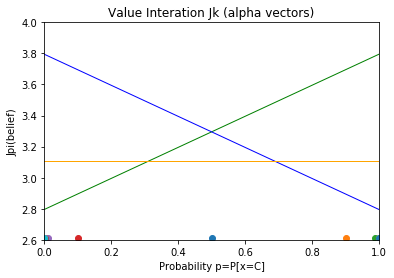

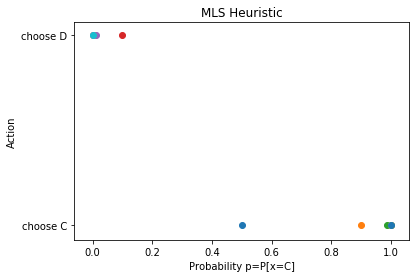

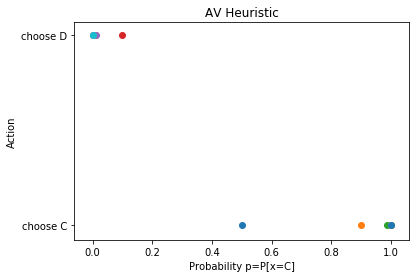

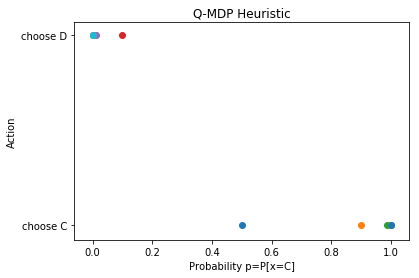

Pelos gráficos acima conclui-se que todas as acções para os beliefs calculados estão de acordo com a optimal policy dos alpha vectors, excepto para o belief inicial [0.5, 0.5] em que é escolhida a acção peek para os alpha vectors.


In [7]:
import matplotlib.pyplot as plt

Vc = [2.795, 3.795]
Vcx = [0, 1]
Vcy = [2.795, 3.795]

Vd = [3.795, 2.795]
Vdx = [0, 1]
Vdy = [3.795, 2.795]

Vp = [3.105, 3.105]
Vpx = [0, 1]
Vpy = [3.105, 3.105]

#define axis values
plt.axis([0, 1, 2.6, 4])
#draw each vector
plt.plot(Vcx, Vcy, "k-", lw = 1, color = 'green')
plt.plot(Vdx, Vdy, "k-", lw = 1, color = 'blue')
plt.plot(Vpx, Vpy, "k-", lw = 1, color = 'orange')
#draw each belief probability for Clubs
for b in belief_list:
    plt.scatter(b[0], 2.61)
#define the plot
plt.title("Value Interation Jk (alpha vectors)")
plt.xlabel("Probability p=P[x=C]")
plt.ylabel("Jpi(belief)")
plt.show()

#MLS Heuristic
#define axis y values into actions
y = np.arange(3)
plt.yticks(y, A)
#draw each belief probability for Clubs
i = 0
for b in belief_list:
    if MLS_actions[i] == A[0]:
        plt.scatter(b[0], 0)
    elif MLS_actions[i] == A[1]:
        plt.scatter(b[0], 1)
    elif MLS_actions[i] == A[2]:
        plt.scatter(b[0], 2)
    i += 1
        
#define the plot
plt.title("MLS Heuristic")
plt.xlabel("Probability p=P[x=C]")
plt.ylabel("Action")
plt.show()

#AV Heuristic
#define axis y values into actions
plt.yticks(y, A)
#draw each belief probability for Clubs
i = 0
for b in belief_list:
    if AV_actions[i] == A[0]:
        plt.scatter(b[0], 0)
    elif AV_actions[i] == A[1]:
        plt.scatter(b[0], 1)
    elif AV_actions[i] == A[2]:
        plt.scatter(b[0], 2)
    i += 1
        
#define the plot
plt.title("AV Heuristic")
plt.xlabel("Probability p=P[x=C]")
plt.ylabel("Action")
plt.show()

#Q-MDP Heuristic
#define axis y values into actions
plt.yticks(y, A)
#draw each belief probability for Clubs
i = 0
for b in belief_list:
    if QMDP_actions[i] == A[0]:
        plt.scatter(b[0], 0)
    elif QMDP_actions[i] == A[1]:
        plt.scatter(b[0], 1)
    elif QMDP_actions[i] == A[2]:
        plt.scatter(b[0], 2)
    i += 1
        
#define the plot
plt.title("Q-MDP Heuristic")
plt.xlabel("Probability p=P[x=C]")
plt.ylabel("Action")
plt.show()

print("Pelos gráficos acima conclui-se que todas as acções para os beliefs calculados estão de acordo com a "\
      "optimal policy dos alpha vectors, excepto para o belief inicial [0.5, 0.5] em que é escolhida a acção peek "\
      "para os alpha vectors.")